#**Data Cleaning using SQL**

###**By Chee Chee Hsu**


##**1. Introduction**

#### This is a project in which I use SQL to clean data and then explore it. Cleaning the data is also known as "wrangling" or "pre-processing" the data. This is done to remove inconsistencies in the data and make it easier to analyze later.

#### The dataset used contains the records of animal bites reported to the Metro Department of Public Health in Louisville, Kentucky.  The dataset can be found [here.](https://data.louisvilleky.gov/dataset/environmental-health-bulk-data/resource/af2c0cc3-280d-4812-871a-f33fceefc62e#{view-graph:{graphOptions:{hooks:{processOffset:{},bindEvents:{}}}},currentView:!grid,graphOptions:{hooks:{processOffset:{},bindEvents:{}}},view-grid:{columnsWidth:[{column:!bite_date,width:185},{column:!release_date,width:96}]}})

<a name="id"></a>

#### The code I used was written in SQLite. Most versions of SQL are very similar, but there may be some differences in syntax from version to version.




[link text](https://data.louisvilleky.gov/dataset/environmental-health-bulk-data/resource/af2c0cc3-280d-4812-871a-f33fceefc62e#{view-graph:{graphOptions:{hooks:{processOffset:{},bindEvents:{}}}},currentView:!grid,graphOptions:{hooks:{processOffset:{},bindEvents:{}}},view-grid:{columnsWidth:[{column:!bite_date,width:185},{column:!release_date,width:96}]}})

<a name="id"></a>
# Heading
This is the cell I'm linking to

##**2. Preview the data**

#### Let's take a look at the data to see what types of information it contains. The name of the table is **"Animal_Bites_orig"**.


In [ ]:
# Look at the top 5 rows to preview the dataset
SELECT *
FROM Animal_Bites_orig
LIMIT 5

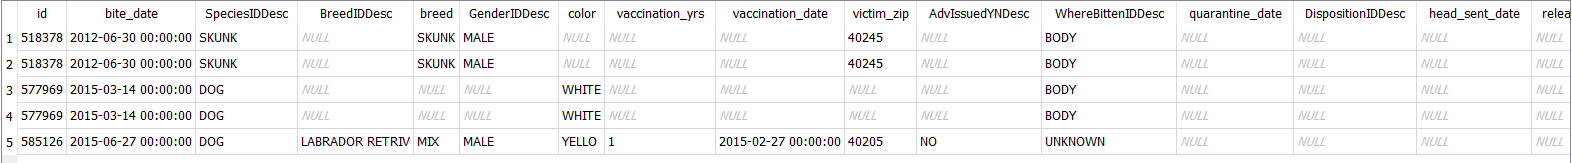

#### We see that the dataset contains many "features" or "attributes". The attributes include the "id", "bite_date", species ("SpeciesIDDesc"), and  location of the incident ("victim_zip"). The dataset also contains several irrelevant attributes as well as missing values. We will "clean" these last two items to make the data easier to use.

##**3. Remove Un-needed Attributes**
#### Let's process certain attributes we don't need.  For example, if we plan to construct a time-series of animal bite incidents or simply explore the bites themselves, then we don’t need attributes related to what happened after the bites, such as "quarantine_date", etc.

#### When we explore the data, we see that 9260 records have a "SpeciesIDDesc" but no "breed". So we will remove the "breed" attribute. But before we do, we also see that there are 6 records that have a "breed" but no "SpeciesIDDesc". We will first fill in the "SpeciesIDDesc" with the "breed" to complete these 6 records. Then we will remove the attribute "breed", since 9260 records (nearly 73%) of the data does not have a "breed".

#### First we fill in the "SpeciesIDDesc" with the "breed" to complete those 6 records:


In [ ]:
## First identify the records that do not have 'SpeciesID' but do have 'breed'
SELECT  *   
FROM Animal_Bites_orig
WHERE SpeciesIDDesc ISNULL and breed IS NOT NULL;

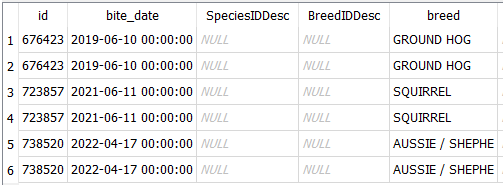

In [ ]:
# Then fill in the records with no "SpeciesIDDesc" but do have a "breed"
UPDATE Animal_Bites_orig
SET SpeciesIDDesc = Breed
	WHERE SpeciesIDDesc ISNULL and breed IS NOT NULL;

# Check the records updated
SELECT  *   
FROM Animal_Bites_orig
WHERE breed IN ('GROUND HOG', 'SQUIRREL', 'AUSSIE / SHEPHE')
	AND SpeciesIDDesc <> 'OTHER'

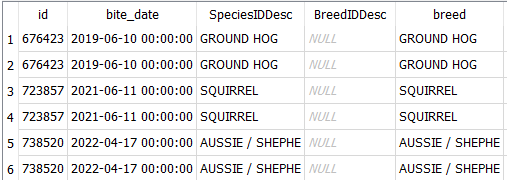

#### Then we remove the attributes we don't need with the following code. We will remove the following attributes: [breed, vaccination_yrs, vaccination_date, AdvIssudYNDesc, quarantine_date, DispositionIDDesc, head_sent_date, release_date, ResultsIDDesc,FollowupYNDesc]. The remaining attributes we keep and put into a new table, **"Animal_Bites_new"**. 

In [ ]:
# Remove the un-needed attributes. Put the remaining attributes into a new table
PRAGMA foreign_keys=off;

CREATE TABLE IF NOT EXISTS Animal_Bites_new
	( id INTEGER,
	  bite_date NUMERIC NULL,
	  SpeciesIDDesc TEXT NULL,
	  BreedIDDesc TEXT NULL,
	  GenderIDDesc TEXT NULL,
	  color TEXT NULL,
	  victim_zip INTERGER NULL,
	  WhereBittenIDDesc INTEGER NULL
	);

INSERT INTO Animal_Bites_new (id, bite_date, SpeciesIDDesc, BreedIDDesc, GenderIDDesc, color, victim_zip, WhereBittenIDDesc)
  SELECT id, bite_date, SpeciesIDDesc, BreedIDDesc, GenderIDDesc, color, victim_zip, WhereBittenIDDesc
  FROM Animal_Bites_orig;

PRAGMA foreign_keys=on;

# Check the new resulting table
SELECT *
FROM Animal_Bites_new
ORDER BY BreedIDDesc
LIMIT 5

#### We check the resulting table, **"Animal_Bites_new"**. It has only the 8 useful attributes we want.

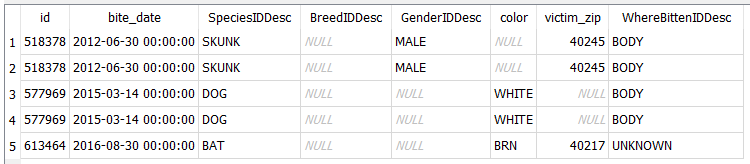

##**4. Replace Missing Data When Possible**

#### We can work with the missing values now that only the relevant attributes remain. A common practice is to replace (AKA, "impute") missing values, instead of removing them altogether, in order to try to keep as much data as possible.

#### 1. For records that do not have a "SpeciesIDDesc", but do have a "BreedIDDesc", we can use the "BreedIDDesc" (ie, "pit bull") to find a value to replace the "SpeciesIDDesc" (ie, "dog"). 

#### 2. After certain records have values added in Step 1 above, any remaining records with a "BreedIDDesc" that is NULL will be replaced with "UNKNOWN".

#### 3. Except for "bite_date" and "victim_zip", the other attributes do not need a particular value to be used. Using "UNKNOWN" in place of "NULL" values will be sufficient here also.

#### So "UNKNOWN" will be applied to the attributes "BreedIDDesc", "GenderIDDesc", "color", and "WhereBittenIDDesc".

In [ ]:
# If SpeciesIDDesc is missing, add values based on the BreedIDDesc
UPDATE Animal_Bites_new
SET SpeciesIDDesc = 'DOG'
	WHERE SpeciesIDDesc ISNULL AND BreedIDDesc IS NOT NULL

# Replace missing values in BreedIDDesc with 'UNKNOWN'
UPDATE Animal_Bites
SET BreedIDDesc = 'UNKNOWN'
  WHERE BreedIDDesc IS NULL;

# Replace missing values in GenderIDDesc with 'UNKNOWN'
UPDATE Animal_Bites_new
SET GenderIDDesc = 'UNKNOWN'
  WHERE GenderIDDesc IS NULL;

# Replace missing values in color with 'UNKNOWN'
UPDATE Animal_Bites_new
SET COLOR = 'UNKNOWN'
  WHERE COLOR IS NULL;

# Replace missing values in WhereBittenIDDesc with 'UNKNOWN'
UPDATE Animal_Bites_new
SET WhereBittenIDDesc = 'UNKNOWN'
  WHERE WhereBittenIDDesc IS NULL;

#### We check the updated table and see that "BreedIDDesc", "GenderIDDesc", "color", and "WhereBittenIDDesc" are filled in with "UNKNOWN" in place of "NULL".

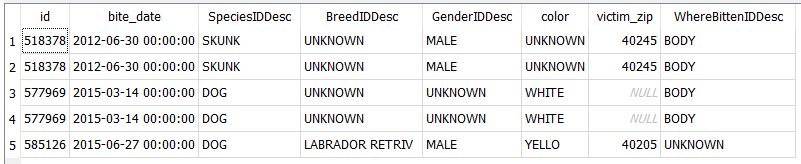

## **5. Remove Missing Data**
### Finally, records missing values for certain key attributes will be removed altogether. For example, if we perform a time-series and geographic analysis, then records that are missing the date and location are not useful and should be discarded.

### So records that are missing "bite_date", "SpeciesIDDesc", and "victim_zip" attributes will be deleted.


In [ ]:
# Remove rows with missing values in remaining columns   
DELETE FROM Animal_Bites_new
WHERE bite_date IS NULL
   OR SpeciesIDDesc IS NULL
   OR victim_zip IS NULL;

### Here is the dataset after records with missing values have been discarded. Now none of the records have a "NULL" value.

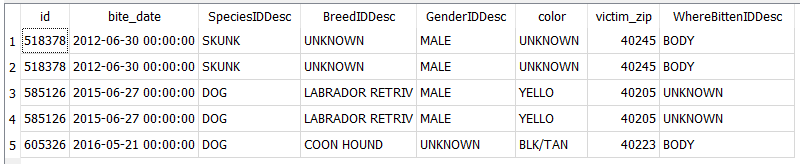

## **6. After the Data Is Cleaned and Wrangled, Explore it**

#### Now that the data has been painstakingly cleaned (ie, "wrangled" or "pre-processed"), we can query the data to find insights.

#### This query example shows the top 5 dog breeds that cause the most bites.


In [ ]:
# Find the Top 5 dog breeds that have the most bite cases
SELECT BreedIDDesc, COUNT(BreedIDDesc) AS Total_Incidents
FROM Animal_Bites_new
WHERE SpeciesIDDesc = 'DOG'
  AND BreedIDDesc <> 'UNKNOWN'
GROUP BY BreedIDDesc
ORDER BY Total_Incidents DESC
LIMIT 5

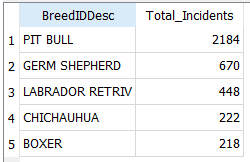

#### This query shows who bites the most of all the other animals who are not dogs.

In [ ]:
# Find the other animals who bite the most
SELECT SpeciesIDDesc, COUNT(SpeciesIDDesc) AS Total_Other_Animal_Incidents
FROM Animal_Bites_new
WHERE SpeciesIDDesc <> 'DOG'
GROUP BY SpeciesIDDesc
ORDER BY Total_Other_Animal_Incidents DESC

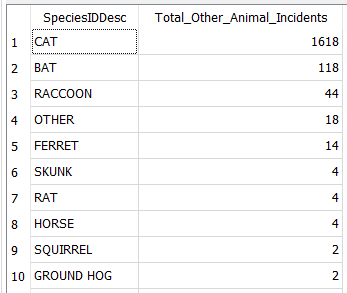

### **7. Conclusion**

#### So now we have seen how we can use SQL to clean data by removing un-needed attributes, imputing missing values, and removing records lacking critical fields required for analysis.

#### Being able to wrangle data with SQL adds another tool to our data science toolbox!
